## overview
- predict performance at next step given next domain to practice on

In [630]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random

Initialize run

wandb initialization

Data

In [631]:
df = pd.read_csv("data/filtered_ds.csv")

In [632]:
df["start_time_min"] = df["start_time_min"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [633]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [634]:
## given a dataframe of a single patient, order the sessions by time and returns a dataframe with 14 domain scores
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1, 14))
    scores = np.zeros((len(data) - 1, 14 * 2))
    patient_ids = data["patient_id"].to_numpy().reshape(-1, 1)[1:]
    i = 0
    
    data = data.sort_values(by=["start_time_min"])

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # at the last row, create target data
        if i == len(data) - 1:
            target = copy.deepcopy(scores[:, -14:])
            target = np.vstack((target, score))
            target = target[1:, :]
            break
        # if it's not the first, hot code encode the domain with the first 14 columns
        if i != 0:
            for d in domains:
                scores[i - 1, int(d - 1)] = 1
        # set score
        scores[i, -14:] = score
        i += 1
        
    scores = np.hstack((patient_ids, scores))
    scores = np.hstack((scores, target))
    
    scores_df = pd.DataFrame(scores, columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] + ["domain %d score" % i for i in range(1, 15)] + ["domain %d target" % i for i in range(1, 15)])
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [635]:
data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_94491/1806359856.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [636]:
## pick a random patient for case study
pid = random.choice(pd.unique(data["patient_id"]))
# pid = 281737
## save the patient's data
case_study_data = copy.deepcopy(data[data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = data.drop(data[data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [637]:
model_data = model_data.drop(["patient_id"], axis=1)

In [638]:
def filter_nonzero_rows(df, max_zeros, column_names=["domain %d score" %i for i in range(1, 15)]):
    # only use the score columns when counting 0s
    scores = df[column_names]
    # Count number of zeros in each row
    zeros_count = (scores == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [639]:
model_data = filter_nonzero_rows(model_data, 0)

In [640]:
def generate_random_array(rows, cols, ratio_of_zeros):
    total_elements = rows * cols
    num_zeros = int(total_elements * ratio_of_zeros)
        
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign zeros to the array
    indices = np.random.choice(total_elements, num_zeros, replace=False)
    array.ravel()[indices] = 0
    
    return array

In [641]:
def generate_mask(data):
    rows, cols = data.shape
    assert(cols == 14)
    domains_masked = generate_random_array(rows, cols, 0.3)
    return data * domains_masked

In [642]:
target = copy.deepcopy(model_data[["domain %d target" %i for i in range(1, 15)]])
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
model_data[score_columns] = generate_mask(model_data[score_columns])

In [643]:
model_data = model_data[encoding_columns + score_columns]
model_data = model_data.to_numpy()
target = target.to_numpy()

In [644]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [645]:
model_data_scores = create_missing_indicator(model_data[:, -14:])
model_data = np.hstack((model_data[:, :14], model_data_scores))
# target = create_missing_indicator(target)

Model

In [646]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

masking

In [647]:
def missing(arr):
    return arr[0] == arr[1]

Training

In [648]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 3)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            ## construct target: if not the targeted domain, then set as whatever is reconstructed
            # if the targeted domain, then use ground truth
            target = np.zeros((14,))
            targeted_domains = np.where(session[:14] == 1)[0]
            scores = session[14:][::2]
            for d in range(w):
                if d in targeted_domains:
                    target[d] = y_train[i, d]
                else:
                    target[d] = scores[d]
            target = target.reshape(1, w)
            target = torch.from_numpy(target).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 3)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.tensor(y_val[k]).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [649]:
num_runs = 5

In [650]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = NN()
    epochs = 10
    lr = 0.0075

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(model_data, target, test_size=0.50)
    with torch.no_grad():
        predictions = model(torch.tensor(x_train).type(torch.float32))
        zero_loss = loss_function(torch.tensor(predictions).type(torch.float32), torch.tensor(y_train).type(torch.float32))

        predictions = model(torch.tensor(x_val).type(torch.float32))
        zero_loss_val = loss_function(torch.tensor(predictions).type(torch.float32), torch.tensor(y_val).type(torch.float32))
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_94491/1696147158.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss = loss_function(torch.tensor(predictions).type(torch.float32), torch.tensor(y_train).type(torch.float32))
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_94491/1696147158.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss_val = loss_function(torch.tensor(predictions).type(torch.float32), torch.tensor(y_val).type(torch.float32))
/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 14])). Thi

In [651]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

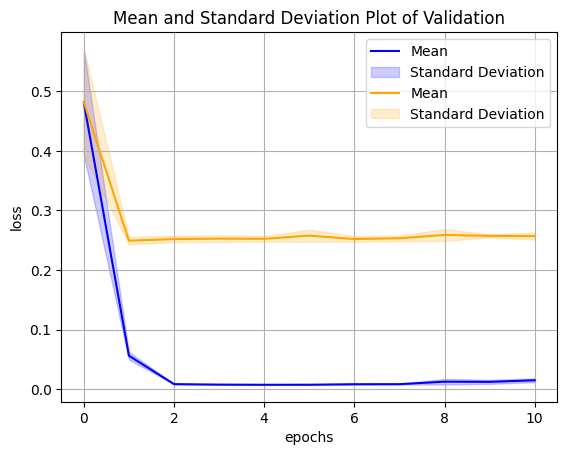

In [652]:
# Defining the Plot Style

# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# wandb.log(
#     {
#         "train val loss": wandb.plot.line_series(
#             xs=range(1, epochs + 1),
#             ys=[losses, val_losses],
#             keys=["Train", "Validation"],
#             title="training and validation loss",
#             xname="epochs",
#         )
#     }
# )

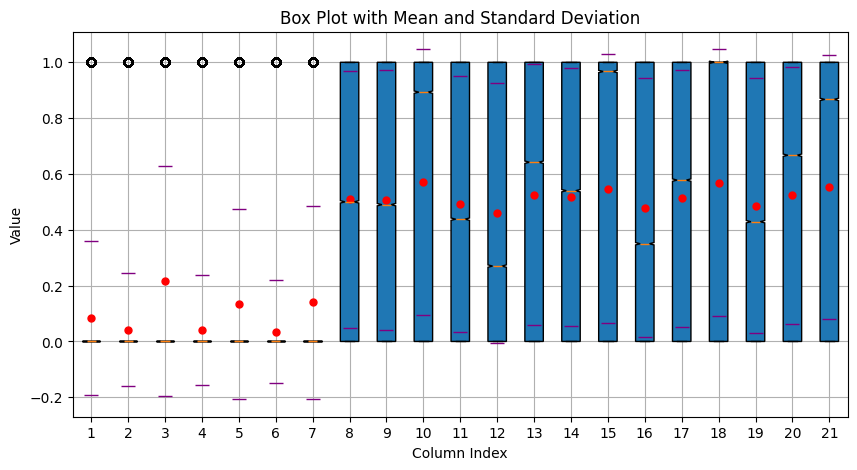

In [653]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

enhanced_box_plot(model_data[:, 0::2])

In [654]:
np.mean(x_train, axis=0)

array([0.08423453, 0.16339292, 0.04165379, 0.13476054, 0.2174943 ,
       0.05380711, 0.04160965, 0.00854852, 0.13295078, 0.07196351,
       0.03532701, 0.19318767, 0.13815935, 0.03438535, 0.50965061,
       0.48943715, 0.50584944, 0.49615159, 0.56975424, 0.43140812,
       0.4930688 , 0.50534215, 0.45956073, 0.54158692, 0.52495573,
       0.47226343, 0.51899367, 0.48790694, 0.54834578, 0.45241932,
       0.47889583, 0.52075105, 0.51222581, 0.48446367, 0.56896962,
       0.42885279, 0.48776001, 0.51413803, 0.52290314, 0.47642004,
       0.55029879, 0.44942166])

### Visualization
- visualize individual patient's trajectory (ground truth vs prediction vs imputation?)
- looks at overall score and next domain error

In [655]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [656]:
# takes in a matrix, returns a list mean along rows
def get_score(data):
    return np.mean(data, axis=1)

In [657]:
# get ground truth scores (overall)
GT_scores = get_score(case_study_data[column_names].to_numpy())

In [658]:
# get prediction scores
model.eval()
with torch.no_grad():
    test_data = case_study_data[encoding_columns + score_columns].to_numpy()
    test_data_scores = create_missing_indicator(test_data[:, -14:])
    test_data = np.hstack((test_data[:, :14], test_data_scores))
    predictions = model(torch.from_numpy(test_data).type(torch.float32)).detach().numpy()

prediction_scores = get_score(predictions)

In [659]:
def remove_zero_columns(df1, df2):
    """
    Removes columns from the second DataFrame that correspond to all-zero columns in the first DataFrame.

    Parameters:
    - df1 (pd.DataFrame): A DataFrame where some columns might have all elements as zero.
    - df2 (pd.DataFrame): A DataFrame from which the corresponding all-zero columns in df1 will be removed.

    Returns:
    - pd.DataFrame: A modified DataFrame with the all-zero columns removed from df2.
    """
    # Check that the number of columns in df1 and df2 match
    if df1.shape[1] != df2.shape[1]:
        raise ValueError("Both DataFrames must have the same number of columns.")

    # Find columns in the first DataFrame that have all zeros
    zero_columns = df1.columns[(df1 == 0).all()]

    # Remove the corresponding columns from the second DataFrame
    filtered_df = df2.drop(columns=zero_columns)

    return filtered_df

In [660]:
# Calculate the difference
difference = predictions - case_study_data[score_columns].to_numpy()
difference = pd.DataFrame(data=difference, columns=column_names)
difference = remove_zero_columns(case_study_data[score_columns], difference)

In [661]:
case_study_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,0.0,0.0,0.667,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.273,0.0
1,0.0,0.0,0.667,0.214,0.050,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.273,0.0
2,0.0,0.0,0.667,0.214,0.050,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.455,0.0
3,0.0,0.0,0.667,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.455,0.0
4,0.0,0.0,0.667,0.072,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.455,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.0,1.0,1.000,0.500,0.252,0.227,0.0,0.0,0.787,0.485,0.6,0.467,0.924,0.0
476,0.0,1.0,1.000,0.500,0.252,0.227,0.0,0.0,0.787,0.485,0.6,0.467,0.924,0.0
477,0.0,1.0,1.000,0.500,0.155,0.227,0.0,0.0,0.787,0.485,0.6,0.467,0.924,0.0
478,0.0,1.0,1.000,0.500,0.155,0.227,0.0,0.0,0.787,0.485,0.6,0.479,0.924,0.0


In [662]:
difference

,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score
0,0.948060,0.054160,0.035190,-0.027924,-0.019675,0.909487,-0.068783,1.032223,0.054536,0.120356
1,0.968270,0.020214,0.048808,0.187597,0.948462,0.014199,-0.048650,0.018694,0.016461,0.130281
2,0.961351,-0.024094,-0.171115,-0.096408,-0.024910,0.904217,0.921735,0.962424,0.040682,0.069428
3,0.014711,0.019010,0.433876,0.299494,0.953768,0.903565,-0.065692,0.034269,0.034745,0.066649
4,0.017265,0.082161,0.016335,0.169142,0.952319,0.017808,0.970841,0.016553,1.005898,0.088138
...,...,...,...,...,...,...,...,...,...,...
475,-0.019307,0.012743,0.174310,0.080341,-0.135012,0.092142,0.073341,0.189621,0.043242,0.049353
476,-0.015393,0.000081,0.210761,0.167741,-0.082180,-0.010046,0.052419,0.132796,-0.014227,0.036229
477,-0.016517,0.011336,0.130964,0.116166,-0.015238,0.038523,0.082310,0.239116,0.177494,0.009579
478,-0.019728,0.012994,0.172389,0.128635,-0.135302,0.078974,0.069286,0.182313,0.038284,0.047769


In [663]:
np.mean(difference ** 2, axis=1).shape

(480,)

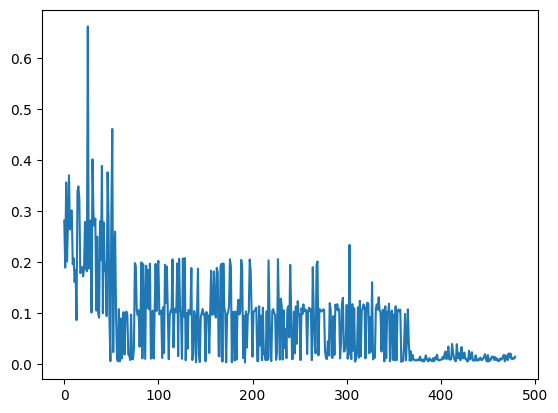

In [664]:
plt.figure()
plt.plot(range(len(difference)), np.mean(difference ** 2, axis=1))

In [665]:
predictions = pd.DataFrame(data=predictions, columns=column_names)

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of labels (14).

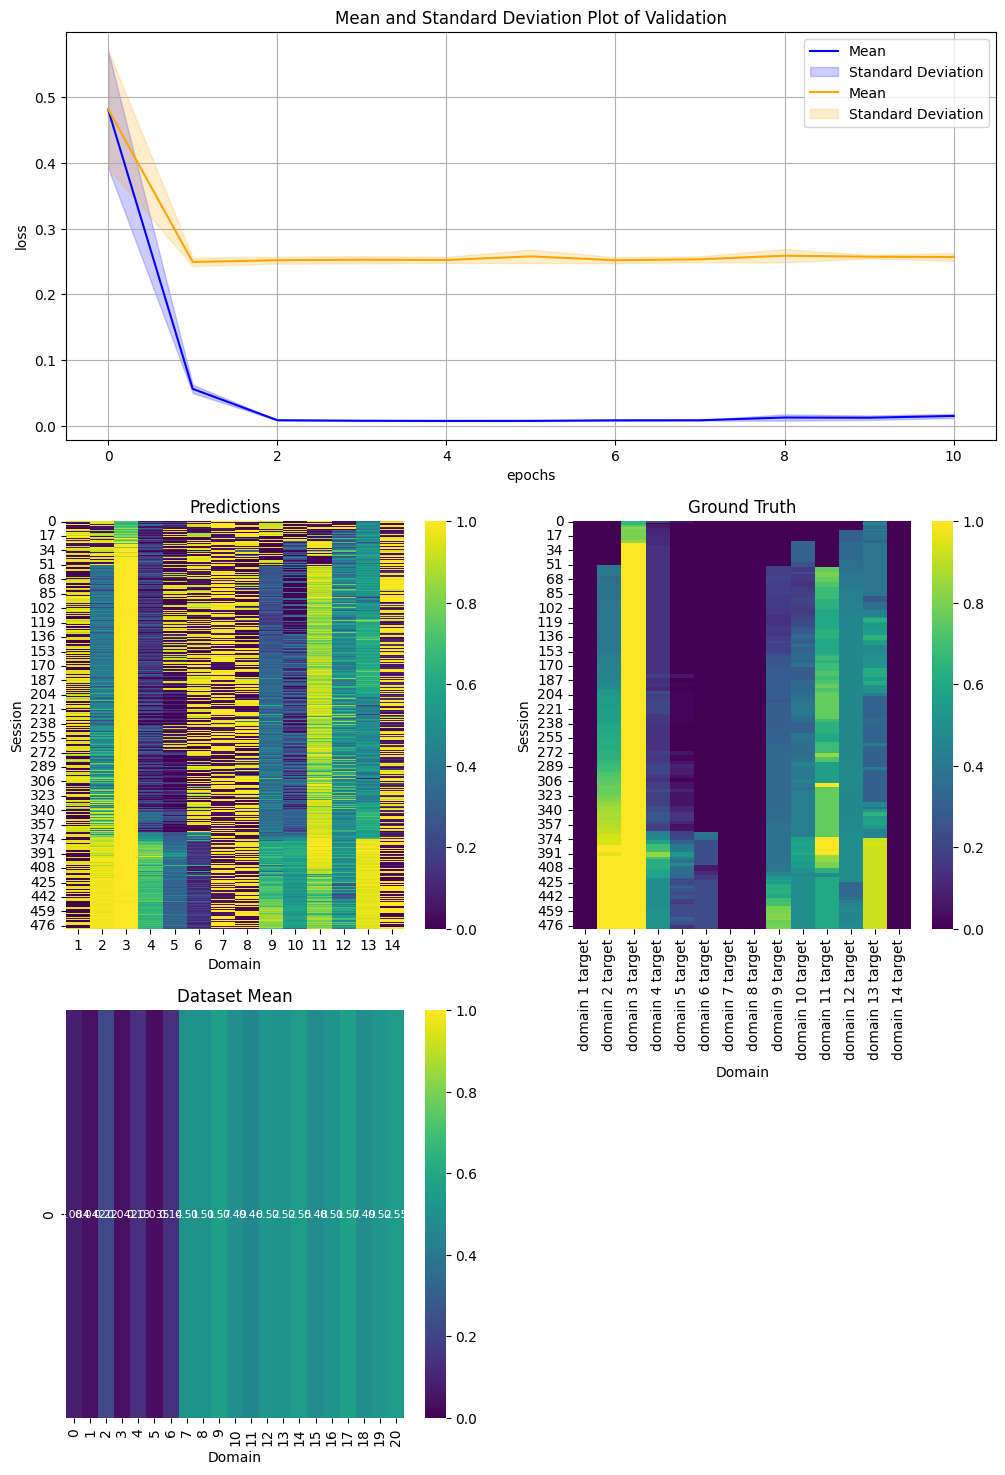

In [666]:
# Create a figure for subplots
fig = plt.figure(figsize=(12, 18))  # Increase figure size if necessary

# set vmin and vmax
vmin = 0
vmax = 1

with torch.no_grad():
    plt.subplot(3, 1, 1)
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# Plotting the first matrix heatmap
plt.subplot(3, 2, 3)
sns.heatmap(predictions.rename(columns=column_rename_dict), cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Predictions")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the second matrix heatmap
plt.subplot(3, 2, 4)
sns.heatmap(case_study_data.iloc[:, -14:].rename(columns=column_rename_dict), cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Plotting the third matrix heatmap
ax = plt.subplot(3, 2, 5)
mean_data = np.mean(x_train, axis=0)[::2].reshape(1, -1)
sns.heatmap(mean_data, cmap="viridis", cbar=True, annot=True, annot_kws={"size": 8}, vmin=vmin, vmax=vmax)
plt.title("Dataset Mean")
plt.xlabel("Domain")
ax.set_xticklabels(range(1, 15))
ax.set_yticklabels("")

# Heatmap of difference between two matrices
# Plotting the heatmap
plt.subplot(3, 2, 6)
sns.heatmap(difference.rename(columns=column_rename_dict), cmap="coolwarm", cbar=True, center=0, vmin=-1, vmax=1)
plt.title("Differences Between Prediction and Ground Truth")
plt.xlabel("Domain")
plt.ylabel("Session")

# Adjust the spacing between the plots and margins of the figure
fig.suptitle("patient %d" % pid, size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# Show the plot
plt.show()

In [ ]:
# torch.save(model.state_dict(), "model/model.pt")
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model/model.pt')
# run.log_artifact(artifact)

In [ ]:
# wandb.unwatch()
# wandb.finish()